<h1 align="center">Theano</h1>

In [1]:
import sys
sys.executable

'/Users/dmitrys/anaconda/bin/python3'

In [2]:
sys.path.append("/Users/dmitrys/anaconda/lib/python3.6/site-packages")

In [3]:
# #!pip install numpy matplotlib   
# !pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
# !pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

### Разминка

In [4]:
import theano
import theano.tensor as T

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### будущий параметр функции -- символьная переменная

In [6]:
N = T.scalar('a dimension', dtype='float32')

#### рецепт получения квадрата -- орперации над символьными переменным

In [7]:
result = T.power(N, 2)

#### theano.grad(cost, wrt)

In [8]:
grad_result = theano.grad(result, N) 

#### компиляция функции "получения квадрата"

In [9]:
sq_function = theano.function(inputs=[N], outputs=result)
gr_function = theano.function(inputs=[N], outputs=grad_result)

#### применение функции

In [10]:
# Заводим np.array x
xv = np.arange(-10, 10)

# Применяем функцию к каждому x
val = map(float, [sq_function(x) for x in xv])

# Посичтаем градиент в кажой точке
grad = map(float, [gr_function(x) for x in xv])

### Что мы увидим если нарисуем функцию и градиент?

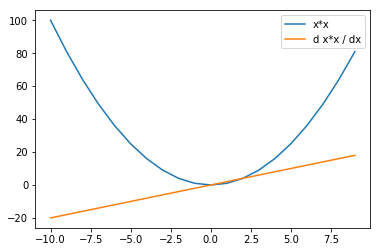

In [11]:
pylab.plot(xv, val, label='x*x')
pylab.plot(xv, grad, label='d x*x / dx')
pylab.legend()

<h1 align="center">Lasagne</h1>

* lasagne - это библиотека для написания нейронок произвольной формы на theano
* В качестве демо-задачи выберем то же распознавание чисел, но на большем масштабе задачи, картинки 28x28, 10 цифр

In [13]:
from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

print('X размера', X_train.shape, 'y размера', y_train.shape)

X размера (50000, 1, 28, 28) y размера (50000,)


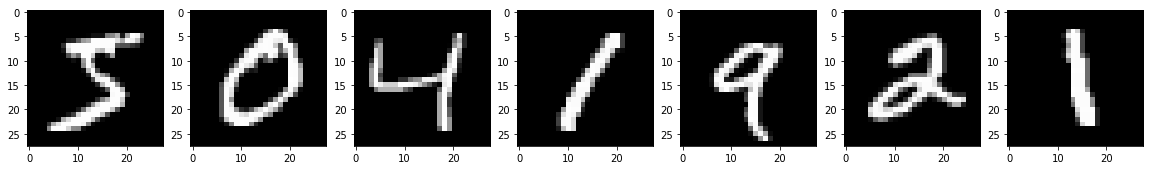

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 20))

for i, ax in enumerate(axes):
    ax.imshow(X_train[i, 0], cmap='gray')

Давайте посмотрим на DenseLayer в lasagne
- http://lasagne.readthedocs.io/en/latest/modules/layers/dense.html
- https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/dense.py#L16-L124 
- Весь содаржательный код тут https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/dense.py#L121 

In [15]:
import lasagne
from lasagne import init
from theano import tensor as T
from lasagne.nonlinearities import softmax

X, y = T.tensor4('X'), T.vector('y', 'int32')

Так задаётся архитектура нейронки

In [157]:
#входной слой (вспомогательный)
net = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=X)

net = lasagne.layers.Conv2DLayer(net, 15, 4, pad='valid') # сверточный слой
net = lasagne.layers.Conv2DLayer(net, 10,  2, pad='full')  # сверточный слой

net = lasagne.layers.DenseLayer(net, num_units=500) # полносвязный слой
net = lasagne.layers.DropoutLayer(net, p=.5)         # регуляризатор

net = lasagne.layers.DenseLayer(net, num_units=200) # полносвязный слой

net = lasagne.layers.DenseLayer(net, num_units=10, nonlinearity=softmax)  # полносвязный слой

In [158]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(net)

In [159]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(net)
print(all_weights)

[W, b, W, b, W, b, W, b, W, b]


In [160]:
#функция ошибки и точности будет прямо внутри
loss = lasagne.objectives.categorical_crossentropy(y_predicted, y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, y).mean()

In [161]:
#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates = lasagne.updates.momentum(loss, all_weights, learning_rate=1e-3, momentum=.9)

In [162]:
#функция, делает updates и возвращащет значение функции потерь и точности
train_fun = theano.function([X, y], [loss, accuracy], updates=updates)
accuracy_fun = theano.function([X, y], accuracy) # точность без обновления весов, для теста

# Процесс обучения

In [167]:
import time 
from mnist import iterate_minibatches

num_epochs = 5  #количество проходов по данным
batch_size = 500 #размер мини-батча

for epoch in range(num_epochs):
    train_err, train_acc, train_batches, start_time = 0, 0, 0, time.time()
    for inputs, targets in iterate_minibatches(X_train, y_train, batch_size):
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    val_acc, val_batches = 0, 0
    for inputs, targets in iterate_minibatches(X_test, y_test, batch_size):
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    print("Epoch %s of %s took %.3f s" % (epoch + 1, num_epochs, time.time() - start_time))
    print(" train loss:\t %.3f"  % (train_err / train_batches))
    print(" train  acc:\t %.3f" % (train_acc * 100 / train_batches), '%')
    print(" test   acc:\t %.3f"  % (val_acc  * 100 / val_batches), '%')
    print(" ")

Epoch 1 of 5 took 49.883 s
 train loss:	 0.089
 train  acc:	 97.274 %
 test   acc:	 96.990 %
 
Epoch 2 of 5 took 49.440 s
 train loss:	 0.085
 train  acc:	 97.372 %
 test   acc:	 96.950 %
 
Epoch 3 of 5 took 46.799 s
 train loss:	 0.081
 train  acc:	 97.522 %
 test   acc:	 97.060 %
 
Epoch 4 of 5 took 47.493 s
 train loss:	 0.082
 train  acc:	 97.422 %
 test   acc:	 97.080 %
 
Epoch 5 of 5 took 51.219 s
 train loss:	 0.078
 train  acc:	 97.534 %
 test   acc:	 97.260 %
 


In [168]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results: \n test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))

Final results: 
 test accuracy:		97.16 %


# Ансамблирование с DropOut

In [169]:
#предсказание нейронки (theano-преобразование)
y_predicted = T.mean([lasagne.layers.get_output(net, deterministic=False) for i in range(10)], axis=0)
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, y).mean()
accuracy_fun = theano.function([X, y], accuracy) # точность без обновления весов, для теста

In [170]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results: \n test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))

Final results: 
 test accuracy:		97.96 %
